In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 
import math
import random
import pickle
import itertools

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, label_ranking_average_precision_score, label_ranking_loss, coverage_error 

from sklearn.utils import shuffle

from scipy.signal import resample

import matplotlib.pyplot as plt

np.random.seed(42)

import pickle
#from sklearn.preprocessing import OneHotEncoder
from keras.utils.np_utils import to_categorical
from keras.models import Model
from keras.layers import Input, Dense, Conv1D, MaxPooling1D, Softmax, Add, Flatten, Activation , Dropout
from keras import backend as K
from keras.optimizers import Adam
from keras.callbacks import LearningRateScheduler, ModelCheckpoint

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("/Users/Usuario/Documents/Python Scripts/F2/database"))

# Any results you write to the current directory are saved as output.

['mitbih_test.csv', 'mitbih_test.csv.zip', 'mitbih_train.csv', 'mitbih_train.csv.zip', 'ptbdb_abnormal.csv', 'ptbdb_abnormal.csv.zip', 'ptbdb_normal.csv', 'ptbdb_normal.csv.zip']


In [2]:
import sklearn
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
from imblearn.over_sampling import RandomOverSampler
np.random.seed(42)


path = '/Users/Usuario/Documents/Python Scripts/F2/database/'

df = pd.read_csv(path + "mitbih_train.csv", header=None)
df_test = pd.read_csv(path + "mitbih_test.csv", header=None)

df_val_train = df.values
X = df_val_train[:, :-1]
y = df_val_train[:, -1].astype(int)

df_val_test = df_test.values
X_test = df_val_test[:, :-1]
Y_test = df_val_test[:, -1].astype(int)

ros = RandomOverSampler(random_state=0)
X_train, Y_train = ros.fit_resample(X, y)

X_train, X_val, Y_train, Y_val = train_test_split(
    X_train,
    Y_train,
    test_size=0.25,
    random_state=42)

shuffle_idx = np.random.permutation(list(range(X_train.shape[0])))
X_train = X_train[shuffle_idx]
Y_train = Y_train[shuffle_idx]

X_train = np.expand_dims(X_train, 2)
X_val = np.expand_dims(X_val, 2)
X_test = np.expand_dims(X_test, 2)

ohe = OneHotEncoder()
Y_test = ohe.fit_transform(Y_test.reshape(-1, 1))


# Visual Input

# Data augmentation

To train properly the model, we sould have to augment all data to the same level. Nevertheless, for a first try, we will just augment the smallest class to the same level as class 1. With that we will be able to have a test set of around 5x800 observations.

# Split

In [3]:
#ohe = OneHotEncoder()
#y_train = ohe.fit_transform(y_train.reshape(-1,1))
#y_test = ohe.transform(y_test.reshape(-1,1))
Y_train=to_categorical(Y_train)
#y_train=y_train.toarray()
#y_test=y_test.toarray()
Y_val=to_categorical(Y_val)

In [4]:
print("X_train", X_train.shape)
print("y_train", Y_train.shape)
print("X_test", X_val.shape)
print("y_test", Y_val.shape)

X_train (271766, 187, 1)
y_train (271766, 5)
X_test (90589, 187, 1)
y_test (90589, 5)


# Model

Now let's re-create the model from the ArXiv Document

In [5]:
n_obs, feature, depth = X_train.shape
batch_size = 500
#batch_size = 500

In [6]:
K.clear_session()

inp = Input(shape=(feature, depth))
C = Conv1D(filters=32, kernel_size=5, strides=1)(inp)
C11 = Conv1D(filters=32, kernel_size=5, strides=1, padding='same')(C)
A11 = Activation("relu")(C11)
C12 = Conv1D(filters=32, kernel_size=5, strides=1, padding='same')(A11)
S11 = Add()([C12, C])
A12 = Activation("relu")(S11)
M11 = MaxPooling1D(pool_size=5, strides=2)(A12)


C21 = Conv1D(filters=32, kernel_size=5, strides=1, padding='same')(M11)
A21 = Activation("relu")(C21)
C22 = Conv1D(filters=32, kernel_size=5, strides=1, padding='same')(A21)
S21 = Add()([C22, M11])
A22 = Activation("relu")(S21)
M21 = MaxPooling1D(pool_size=5, strides=2)(A22)


C31 = Conv1D(filters=32, kernel_size=5, strides=1, padding='same')(M21)
A31 = Activation("relu")(C31)
C32 = Conv1D(filters=32, kernel_size=5, strides=1, padding='same')(A31)
S31 = Add()([C32, M21])
A32 = Activation("relu")(S31)
M31 = MaxPooling1D(pool_size=5, strides=2)(A32)


C41 = Conv1D(filters=32, kernel_size=5, strides=1, padding='same')(M31)
A41 = Activation("relu")(C41)
C42 = Conv1D(filters=32, kernel_size=5, strides=1, padding='same')(A41)
S41 = Add()([C42, M31])
A42 = Activation("relu")(S41)
M41 = MaxPooling1D(pool_size=5, strides=2)(A42)


C51 = Conv1D(filters=32, kernel_size=5, strides=1, padding='same')(M41)
A51 = Activation("relu")(C51)
C52 = Conv1D(filters=32, kernel_size=5, strides=1, padding='same')(A51)
S51 = Add()([C52, M41])
A52 = Activation("relu")(S51)
M51 = MaxPooling1D(pool_size=5, strides=2)(A52)

M52 = (Dropout(0.25))(M51)

F1 = Flatten()(M52)

D1 = Dense(32)(F1)
A6 = Activation("relu")(D1)
D2 = Dense(32)(A6)
D3 = Dense(5)(D2)
A7 = Softmax()(D3)

model = Model(inputs=inp, outputs=A7)

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 187, 1)]     0           []                               
                                                                                                  
 conv1d (Conv1D)                (None, 183, 32)      192         ['input_1[0][0]']                
                                                                                                  
 conv1d_1 (Conv1D)              (None, 183, 32)      5152        ['conv1d[0][0]']                 
                                                                                                  
 activation (Activation)        (None, 183, 32)      0           ['conv1d_1[0][0]']               
                                                                                              

In [7]:
def exp_decay(epoch):
    initial_lrate = 0.001
    k = 0.75
    t = n_obs//(10000 * batch_size)  # every epoch we do n_obs/batch_size iteration
    lrate = initial_lrate * math.exp(-k*t)
    return lrate

lrate = LearningRateScheduler(exp_decay)

In [8]:
adam = Adam(learning_rate = 0.01, beta_1 = 0.9, beta_2 = 0.99)
#adam = Adam(learning_rate = 0.001, beta_1 = 0.9, beta_2 = 0.999)

In [9]:
model.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])

In [10]:
history = model.fit(X_train, Y_train, 
                    epochs=75, 
                    batch_size=batch_size, 
                    verbose=2, 
                    validation_data=(X_val, Y_val), 
                    callbacks=[lrate])

Epoch 1/75
544/544 - 38s - loss: 0.1410 - accuracy: 0.8513 - val_loss: 0.0640 - val_accuracy: 0.9375 - lr: 0.0010 - 38s/epoch - 71ms/step
Epoch 2/75
544/544 - 30s - loss: 0.0590 - accuracy: 0.9427 - val_loss: 0.0368 - val_accuracy: 0.9669 - lr: 0.0010 - 30s/epoch - 54ms/step
Epoch 3/75
544/544 - 29s - loss: 0.0389 - accuracy: 0.9643 - val_loss: 0.0264 - val_accuracy: 0.9772 - lr: 0.0010 - 29s/epoch - 53ms/step
Epoch 4/75
544/544 - 31s - loss: 0.0292 - accuracy: 0.9739 - val_loss: 0.0159 - val_accuracy: 0.9867 - lr: 0.0010 - 31s/epoch - 58ms/step
Epoch 5/75
544/544 - 30s - loss: 0.0242 - accuracy: 0.9789 - val_loss: 0.0188 - val_accuracy: 0.9839 - lr: 0.0010 - 30s/epoch - 56ms/step
Epoch 6/75
544/544 - 30s - loss: 0.0194 - accuracy: 0.9834 - val_loss: 0.0231 - val_accuracy: 0.9809 - lr: 0.0010 - 30s/epoch - 55ms/step
Epoch 7/75
544/544 - 30s - loss: 0.0168 - accuracy: 0.9858 - val_loss: 0.0118 - val_accuracy: 0.9899 - lr: 0.0010 - 30s/epoch - 55ms/step
Epoch 8/75
544/544 - 35s - loss: 0

In [11]:
y_pred = model.predict(X_val, batch_size=500)

182/182 [==============================] - 5s 20ms/step


In [12]:
print(classification_report(Y_val.argmax(axis=1), y_pred.argmax(axis=1)))

              precision    recall  f1-score   support

           0       1.00      0.99      1.00     18082
           1       1.00      1.00      1.00     18083
           2       0.99      1.00      1.00     18112
           3       1.00      1.00      1.00     18004
           4       1.00      1.00      1.00     18308

    accuracy                           1.00     90589
   macro avg       1.00      1.00      1.00     90589
weighted avg       1.00      1.00      1.00     90589



In [13]:
print("ranking-based average precision : {:.3f}".format(label_ranking_average_precision_score(Y_val, y_pred)))
print("Ranking loss : {:.3f}".format(label_ranking_loss(Y_val, y_pred)))
print("Coverage_error : {:.3f}".format(coverage_error(Y_val, y_pred)))

ranking-based average precision : 0.999
Ranking loss : 0.001
Coverage_error : 1.003


Normalized confusion matrix


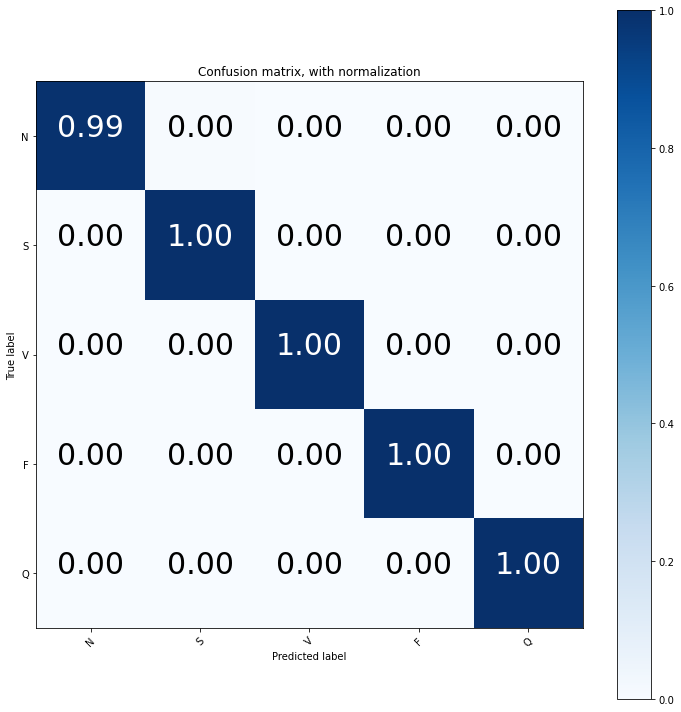

In [14]:
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black", fontsize=30)

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Compute confusion matrix
cnf_matrix = confusion_matrix(Y_val.argmax(axis=1), y_pred.argmax(axis=1))
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure(figsize=(10, 10))
plot_confusion_matrix(cnf_matrix, classes=['N', 'S', 'V', 'F', 'Q'],normalize=True,
                      title='Confusion matrix, with normalization')
plt.show()

In [17]:
FP = cnf_matrix.sum(axis=0) - np.diag(cnf_matrix)  
FN = cnf_matrix.sum(axis=1) - np.diag(cnf_matrix)
TP = np.diag(cnf_matrix)
TN = cnf_matrix.sum() - (FP + FN + TP)

# Sensitivity, hit rate, recall, or true positive rate
RECALL = TP/(TP+FN)
# Specificity or true negative rate
SPECIFICITY = TN/(TN+FP) 
# Precision or positive predictive value
PRECISION = TP/(TP+FP)
# Negative predictive value
NPV = TN/(TN+FN)
# Fall out or false positive rate
FPR = FP/(FP+TN)
# False negative rate
FNR = FN/(TP+FN)
# False discovery rate
FDR = FP/(TP+FP)

# Overall accuracy
ACC = (TP+TN)/(TP+FP+FN+TN)
#F1-score
F1 = 2*((RECALL*PRECISION)/(RECALL+PRECISION))

In [18]:
from statistics import mean, median
from tkinter import N
scores = model.evaluate((X_val),y_pred,batch_size=500)
print("Accuracy: %.2f%%" % (scores[0]*100))
print("Accuracy: %.2f%%" % (scores[1]*100))
PRE = mean(PRECISION)
print("Precision: %.2f%%"% (PRE*100))
#print("Precision: ", PRECISION)
SPE = mean(SPECIFICITY)
print("Specificity: %.2f%%"% (SPE*100))
#print("Specificity", SPECIFICITY)
RE = mean(RECALL)
print("Recall :%.2f%%"% (RE*100))
#print("Recall", RECALL)
#print("F1: ", F1)
F1S = mean(F1)
print("F1-Score :%.2f%%"% (F1S*100))
#Z= mean(1-FNR)*100
#print("Recall:%.2f%%"%Z)

182/182 [==============================] - 4s 20ms/step - loss: 0.0013 - accuracy: 1.0000
Accuracy: 0.13%
Accuracy: 100.00%
Precision: 99.77%
Specificity: 99.94%
Recall :99.77%
F1-Score :99.77%
